In [42]:
import requests
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from sklearn.metrics import roc_curve
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import operator

In [3]:
# API URL
URL = "http://localhost:8080/api/intent?sentence="

# Test using sample phrase
phrase = URL + "Je voudrais manger au restaurant ce soir"
r = requests.get(url = phrase)
  
# Extracting data in json format
data = r.json() 
  
# Printing the output 
print("Results :\n", data) 

Results :
 {'find-train': 0.0031498565804213285, 'irrelevant': 0.16539081931114197, 'find-flight': 0.0028878019656986, 'find-restaurant': 0.7818630337715149, 'purchase': 0.010286015458405018, 'find-around-me': 0.003812880488112569, 'provide-showtimes': 0.02780276909470558, 'find-hotel': 0.004806765355169773}


In [4]:
def makePrediction(sentence):
    phrase = URL + sentence
    r = requests.get(url = phrase)

    data = r.json()
    
    return data

Il existe 8 catégories différentes pour la classifications des intentions dans le modèle proposé :
- find-train : Trouver un train
- irrelevant : Non pertinent
- find-flight : Trouver un vol
- find-restaurant : Trouver un restaurant
- purchase : Trouver des renseignements concernant un achat (prix, disponibilité, etc...) ou Trouver un article 
- find-around-me : Trouver un lieu faisant une activité autour de soi (ou d'une zone donnée dans la requête)
- provide-showtimes : Trouver des informations pour un film
- find-hotel : Trouver un hotel

Performances du modele actuel :
LOSS      P       R       F1
0.015   0.883   0.665   0.758

In [5]:
# Reading training data
with open('../data/processed/training_set.json') as f:
  trainingData = json.load(f)

# Creating a dataframe with the training data
d_trainingData = pd.DataFrame(trainingData)

# Sentence example
print(trainingData[0])

{'intent': 'irrelevant', 'sentence': '850€ maximum pour le loyer, à partir de janvier si possible'}


Item for each intent :
 {'find-train': 143, 'find-flight': 142, 'find-restaurant': 469, 'purchase': 613, 'find-around-me': 383, 'provide-showtimes': 117, 'find-hotel': 316, 'irrelevant': 3852}
Total number of items :  6035


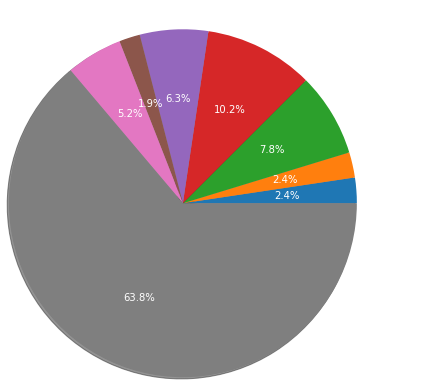

In [6]:
#Counting items in classes
classes = {"find-train":0,
           "find-flight":0,
           "find-restaurant":0,
           "purchase":0,
           "find-around-me":0,
           "provide-showtimes":0,
           "find-hotel":0,
           "irrelevant":0}

for i in range(len(trainingData)):
    intent = trainingData[i]['intent']
    classes[intent] = classes.get(intent, 0) + 1

print("Item for each intent :\n", classes)
print("Total number of items : ", len(trainingData))

#Distribution plot
classesProp = [x/len(trainingData) for x in classes.values()]

plt.rcParams['text.color'] = 'white'
plt.pie(classesProp, labels=classes.keys(), autopct='%1.1f%%', shadow=True, radius=2)
plt.show()

On peut voir sur le graphique ci-dessus que les intents ne sont pas du tout correctement distribués dans le training data. Par conséquent le modèle entraîné va être biaisé et ne marchera pas optimalement.

In [7]:
#METRIQUES A FAIRE
#(Precision, Recall, Fbeta score, AUC-ROC, matrice de confusion)
testSentence = [x["sentence"] for x in trainingData]
testLabel = [x["intent"] for x in trainingData]

results = [makePrediction(x) for x in testSentence]

In [8]:
# Classes results by max
resultsMax = [max(x, key=x.get) for x in results]

Precision: 0.812049
Recall: 0.805800
F1 score: 0.785941
[[[5588   64]
  [ 234  149]]

 [[5891    2]
  [  88   54]]

 [[5694   25]
  [ 164  152]]

 [[5536   30]
  [ 182  287]]

 [[5888    4]
  [  70   73]]

 [[1247  936]
  [  84 3768]]

 [[5917    1]
  [  83   34]]

 [[5312  110]
  [ 267  346]]]


ValueError: multiclass format is not supported

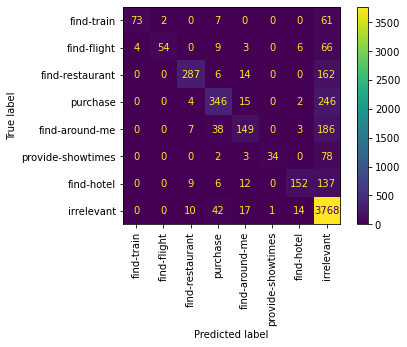

In [45]:
# precision tp / (tp + fp)
precision = precision_score(testLabel, resultsMax, average="weighted")
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testLabel, resultsMax, average="weighted")
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testLabel, resultsMax, average="weighted")
print('F1 score: %f' % f1)

#Confusion matrix for each label
print(multilabel_confusion_matrix(testLabel, resultsMax))

#Global confusion matrix
display_labels = ["find-train","find-flight","find-restaurant","purchase","find-around-me","provide-showtimes","find-hotel","irrelevant"]
cm = confusion_matrix(testLabel, resultsMax, labels=display_labels)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

disp.plot(xticks_rotation='vertical')

In [ ]:
#ROC AUC 
test = pd.DataFrame.from_dict(results).to_numpy()

# https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification
# Compute ROC curve and ROC area for each class
n_classes = 8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()